In [ ]:
import os
import glob

import gc
import imgaug as aug
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import imgaug.augmenters as iaa
import tensorflow as tf
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model,load_model
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from keras.layers import GlobalMaxPooling2D
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from skimage.segmentation import slic
from keras import backend as K


color = sns.color_palette()
%matplotlib inline

#Get Dataset

In [ ]:
!pip install gdown
import gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1QO_3-7IVCo9QOf_fZuwa1yuFEOZgZFmf'
output = 'dataset.zip'  # Ganti 'file_name.zip' sesuai kebutuhan

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1QO_3-7IVCo9QOf_fZuwa1yuFEOZgZFmf
To: /content/dataset.zip
100%|██████████| 2.46G/2.46G [00:27<00:00, 88.3MB/s]


'dataset.zip'

In [ ]:
!unzip dataset.zip -d './data'

Streaming output truncated to the last 5000 lines.
  inflating: ./data/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: ./data/chest_xr

In [ ]:
data_path = Path('/content/data/chest_xray/chest_xray')
train_path = data_path/'train'
test_path = data_path/'test'
val_path = data_path/'val'

In [ ]:
def load_train():
    normal_cases_train = train_path/ 'NORMAL'
    pneumonia_cases_train = train_path / 'PNEUMONIA'

    # Get the list of all the images
    normal_cases = normal_cases_train.glob('*.jpeg')
    pneumonia_cases = pneumonia_cases_train.glob('*.jpeg')
    train_data=[]
    train_label=[]
    for img in normal_cases:
            train_data.append(img)
            train_label.append(0)
    for img in pneumonia_cases:
        train_data.append(img)
        train_label.append(1)
    df=pd.DataFrame(train_data)
    df.columns=['images']
    df['labels']=train_label
    df=df.sample(frac=1).reset_index(drop=True)
    return df

In [ ]:
train_data=load_train()
print(f"Data Train :", len(train_data))

Data Train : 5216


In [ ]:
def load_test():
    normal_cases_test = test_path/ 'NORMAL'
    pneumonia_cases_test = test_path / 'PNEUMONIA'

    # Get the list of all the images
    normal_cases = normal_cases_test.glob('*.jpeg')
    pneumonia_cases = pneumonia_cases_test.glob('*.jpeg')
    test_data=[]
    test_label=[]
    for img in normal_cases:
            test_data.append(img)
            test_label.append(0)
    for img in pneumonia_cases:
        test_data.append(img)
        test_label.append(1)
    df=pd.DataFrame(test_data)
    df.columns=['images']
    df['labels']=test_label
    df=df.sample(frac=1).reset_index(drop=True)
    return df

In [ ]:
test_data=load_test()
print(f"Data Test :", len(test_data))

Data Test : 624


In [ ]:
def prepare_and_load(isval=True):
    if isval==True:
        normal_dir=val_path/'NORMAL'
        pneumonia_dir=val_path/'PNEUMONIA'
    else:
        normal_dir=test_path/'NORMAL'
        pneumonia_dir=test_path/'PNEUMONIA'
    normal_cases = normal_dir.glob('*.jpeg')
    pneumonia_cases = pneumonia_dir.glob('*.jpeg')
    data,labels=([] for x in range(2))
    def prepare(case):
        for img in case:
            img = cv2.imread(str(img))
            img = cv2.resize(img, (224,224))
            if img.shape[2] ==1:
                 img = np.dstack([img, img, img])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32)/255.
            if case==normal_cases:
                label = to_categorical(0, num_classes=2)
            else:
                label = to_categorical(1, num_classes=2)
            data.append(img)
            labels.append(label)
        return data,labels
    prepare(normal_cases)
    d,l=prepare(pneumonia_cases)
    d=np.array(d)
    l=np.array(l)
    return d,l

In [ ]:
val_data,val_labels=prepare_and_load(isval=True)
test_data,test_labels=prepare_and_load(isval=False)

In [ ]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size

    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)

    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['images']
            label = data.iloc[idx]['labels']

            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))

            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])

            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.

            #segmentation
            oig_img=slic(orig_img)

            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            #augmentation
            seq = iaa.OneOf([
                 iaa.Fliplr(), # horizontal flips
                 iaa.Affine(rotate=20), # roatation
                 iaa.Multiply((1.2, 1.5))]) #random brightness
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2

            else:
                count+=1

            if count==batch_size-1:
                break

        i+=1
        yield batch_data, batch_labels

        if i>=steps:
            i=0

#Fine Tuned Model

In [ ]:
def vgg16_model( num_classes=None):

    model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

    x=Dense(1024, activation='relu')(model.layers[-4].output)# add my own dense layer after the last conv block
    x=Dropout(0.7)(x)
    x=Dense(512,activation='relu')(x)
    x=Dropout(0.5)(x)
    x=Dense(2,activation='softmax')(x)
    model=Model(model.input,x)

    return model

In [ ]:
vgg_conv=vgg16_model(2)
for layer in vgg_conv.layers[:-10]:#freeze all layers except the last ten
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

553467096/553467096 [==============================] - 3s 0us/step
<keras.src.engine.input_layer.InputLayer object at 0x7b3b2c58dcf0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b3b2c58ff40> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b3b2bcc05b0> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7b3b2bcc0190> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b3b2bcc1690> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b3b2bcc1ea0> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7b3b2bcc37f0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b3b2bcc3dc0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b3b2bcc3070> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b3b2bcc2200> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7b3b1434a080> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7

In [ ]:
vgg_conv.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
opt = tf.keras.optimizers.legacy.Adam(lr=0.0001, decay=1e-5)
early_stop = EarlyStopping(monitor='loss',patience=3,verbose=1)
vgg_conv.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
batch_size = 20
nb_epochs = 10

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(val_data)))

Number of training and validation steps: 260 and 16


In [ ]:
# # Fit the model
history = vgg_conv.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                              validation_data=(val_data,val_labels),callbacks=[early_stop],
                               class_weight={0:1.0, 1:0.4})

<ipython-input-18-1d1b795af7ea>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = vgg_conv.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,


Epoch 1/10
260/260 [==============================] - 304s 1s/step - loss: 0.1147 - accuracy: 0.9204 - val_loss: 0.0121 - val_accuracy: 1.0000
Epoch 2/10
260/260 [==============================] - 290s 1s/step - loss: 0.0399 - accuracy: 0.9756 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 3/10
260/260 [==============================] - 290s 1s/step - loss: 0.0251 - accuracy: 0.9842 - val_loss: 0.1619 - val_accuracy: 0.8750
Epoch 4/10
260/260 [==============================] - 288s 1s/step - loss: 0.0237 - accuracy: 0.9871 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 5/10
260/260 [==============================] - 288s 1s/step - loss: 0.0235 - accuracy: 0.9862 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 6/10
260/260 [==============================] - 283s 1s/step - loss: 0.0128 - accuracy: 0.9923 - val_loss: 0.1880 - val_accuracy: 0.8750
Epoch 7/10
260/260 [==============================] - 282s 1s/step - loss: 0.0149 - accuracy: 0.9908 - val_loss: 0.3590 - val_accuracy: 0.8750

In [ ]:
loss,acc=vgg_conv.evaluate(test_data,test_labels,batch_size=16)
print('Loss and accuracy',loss,'&',acc)

39/39 [==============================] - 3s 67ms/step - loss: 1.8832 - accuracy: 0.8269
Loss and accuracy 1.8831872940063477 & 0.8269230723381042


##Evaluation

In [ ]:
# Get predictions
pred = vgg_conv.predict(test_data, batch_size=16)
pred = np.argmax(pred, axis=-1)

# Original labels
labels = np.argmax(test_labels, axis=-1)
from sklearn.metrics import classification_report
print(classification_report(labels, pred))

39/39 [==============================] - 3s 69ms/step
              precision    recall  f1-score   support

           0       0.98      0.55      0.70       234
           1       0.79      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.89      0.77      0.79       624
weighted avg       0.86      0.83      0.81       624



<Figure size 640x480 with 0 Axes>

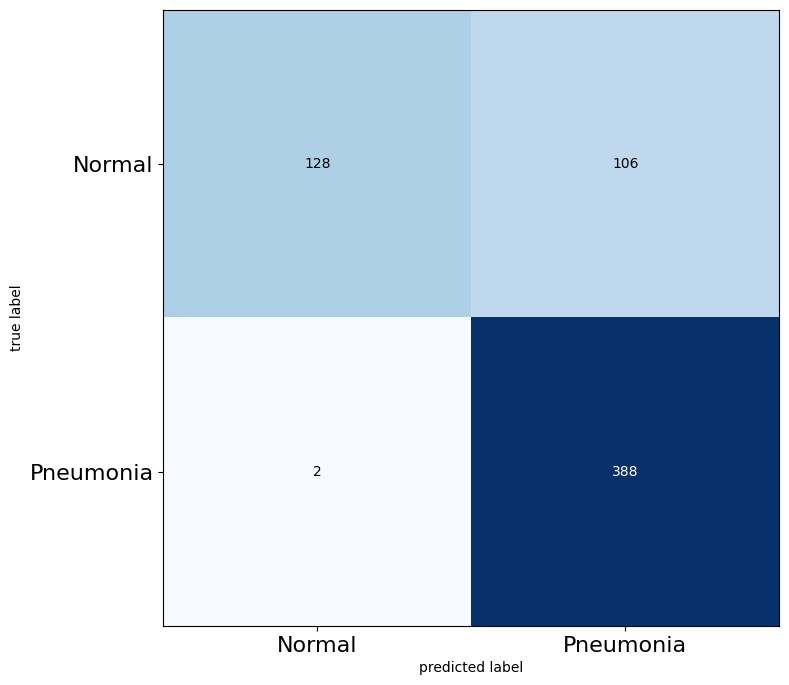

In [ ]:
# Get the confusion matrix
cm  = confusion_matrix(labels, pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [ ]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall/Sensitivity of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall/Sensitivity of the model is 0.99
Precision of the model is 0.79


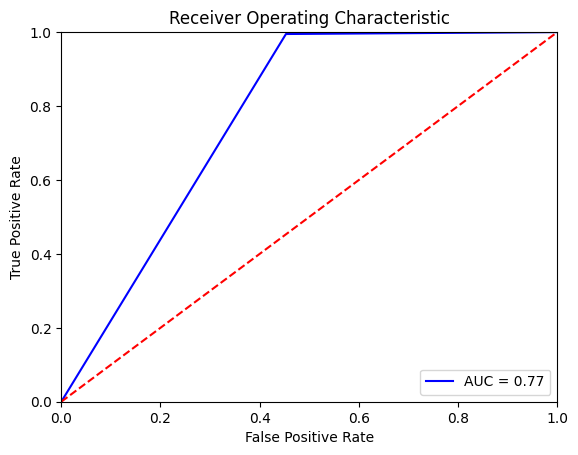

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(labels, pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

{'loss': [0.1147041991353035, 0.03990660980343819, 0.02507917210459709, 0.02369331382215023, 0.023460963740944862, 0.012803490273654461, 0.014919936656951904, 0.01646028272807598, 0.02144084870815277], 'accuracy': [0.9203845858573914, 0.9755769371986389, 0.9842307567596436, 0.9871153831481934, 0.9861538410186768, 0.9923076629638672, 0.9907692074775696, 0.9903846383094788, 0.989230751991272], 'val_loss': [0.012138454243540764, 0.001603408483788371, 0.1618824452161789, 0.001831090310588479, 0.0046301959082484245, 0.18800020217895508, 0.35898977518081665, 0.00034592696465551853, 0.5075104236602783], 'val_accuracy': [1.0, 1.0, 0.875, 1.0, 1.0, 0.875, 0.875, 1.0, 0.9375]}


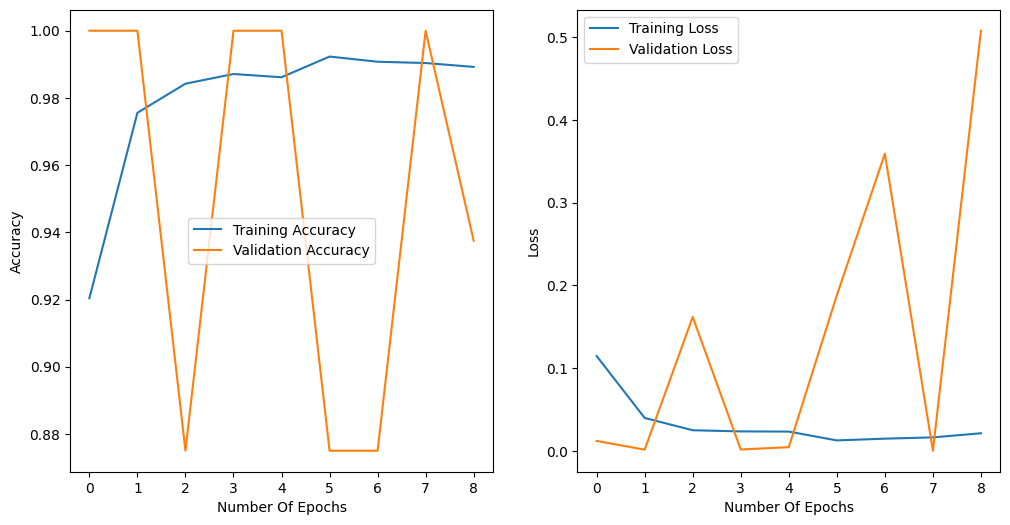

In [ ]:
metrics = history.history
print(metrics)

plt.figure(figsize=(12,6))

#Accuracy
plt.subplot(1,2,1)
plt.plot(metrics['accuracy'], label='Training Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Number Of Epochs")
plt.ylabel("Accuracy")
plt.legend()

#Loss
plt.subplot(1,2,2)
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.xlabel("Number Of Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 16.0 MB/s eta 0:00:00


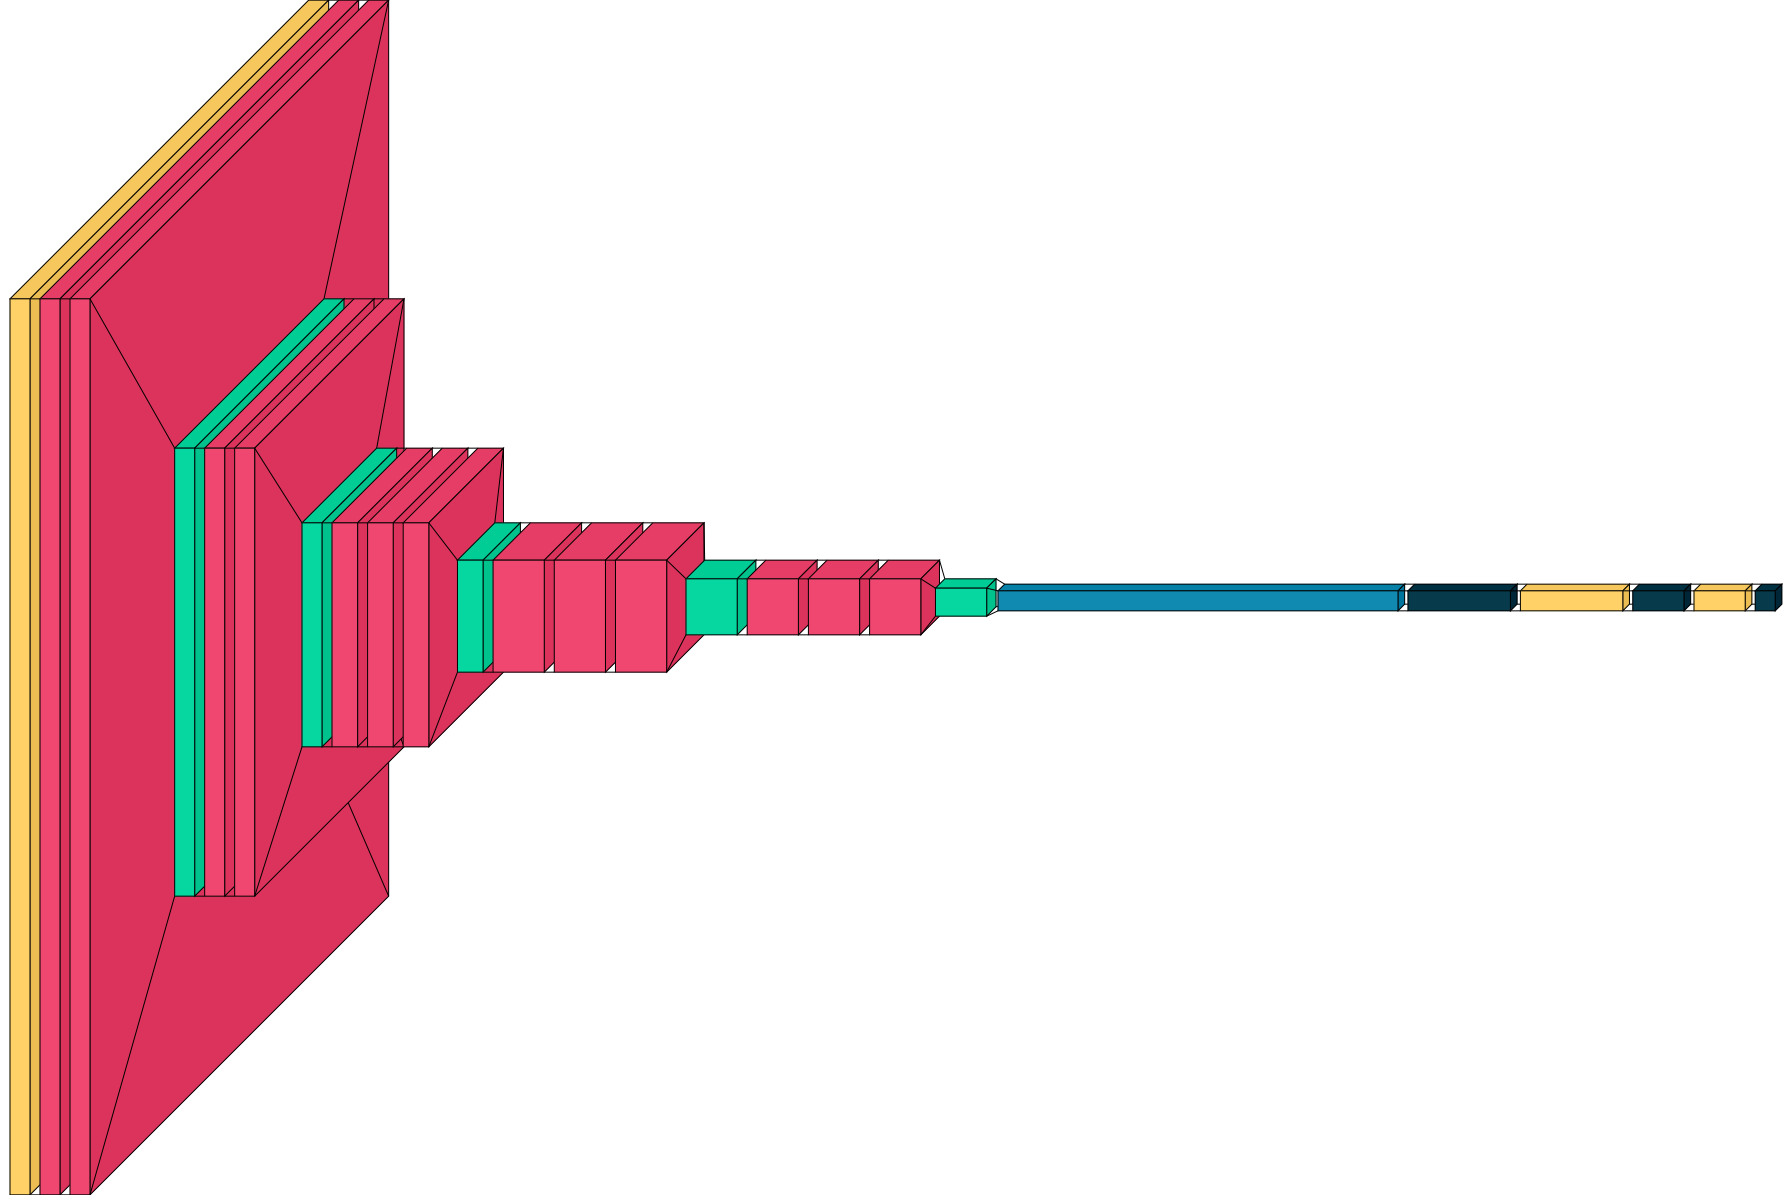

In [ ]:
import visualkeras
visualkeras.layered_view(vgg_conv)

#Save the model

In [ ]:
vgg_conv.save('model_vgg.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
